In [1]:
import os
import errno
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks

import deepcell
from deepcell import model_zoo
from deepcell import losses
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.tracking_utils import load_trks
from deepcell.utils.tracking_utils import save_trks
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters
from deepcell.callbacks import RedirectModel, Evaluate
from deepcell.image_generators import RetinaMovieDataGenerator, RetinaNetGenerator
# from deepcell.model_zoo import shapemask_box

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Helper Functions
From `shape_mask` branch

In [2]:
def train_model(model,
                model_dir=None,
                model_name=None,
                train_dict=None,
                test_dict=None,
                batch_size=1,
                num_classes=1,
                fpb=1,
                backbone_levels=None,
                pyramid_levels=None,
                anchor_params=None,
                n_epoch=16,
                optimizer=Adam(lr=1e-5, clipnorm=0.001),
                lr_sched = rate_scheduler(lr=1e-5, decay=0.99)
                ):
    
    if fpb == 1:
        datagen = RetinaNetGenerator(
            rotation_range=180,
            zoom_range=(0.8, 1.2),
            horizontal_flip=True,
            vertical_flip=True)

        datagen_val = RetinaNetGenerator()

        train_data = datagen.flow(
            train_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

        val_data = datagen_val.flow(
            test_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)
    
    else:
        datagen = RetinaMovieDataGenerator(
            rotation_range=180,
            zoom_range=(0.8, 1.2),
            horizontal_flip=True,
            vertical_flip=True)

        datagen_val = RetinaMovieDataGenerator()

        train_data = datagen.flow(
            train_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            frames_per_batch=fpb,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

        val_data = datagen_val.flow(
            test_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            frames_per_batch=fpb,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

    retinanet_losses = losses.RetinaNetLosses(
        sigma=3.0,
        alpha=0.25,
        gamma=2.0,
        iou_threshold=0.5,
        mask_size=(28,28))

    loss = {
        'regression': retinanet_losses.regress_loss,
        'classification': retinanet_losses.classification_loss,
        'masks': retinanet_losses.mask_loss,
        'final_detection': retinanet_losses.final_detection_loss
        }

    model.compile(loss=loss, optimizer=optimizer)

    iou_threshold = 0.5
    score_threshold = 0.01
    max_detections = 100

    model.fit_generator(
        train_data,
        steps_per_epoch=X_train.shape[0] * X_train.shape[1]// batch_size,
        epochs=n_epoch,
        validation_data=val_data,
        validation_steps=X_test.shape[0] * X_test.shape[1]// batch_size,
        callbacks=[
            callbacks.LearningRateScheduler(lr_sched),
            callbacks.ModelCheckpoint(
                os.path.join(model_dir, model_name + '.h5'),
                monitor='val_loss',
                verbose=1,
                save_best_only=True,
                save_weights_only=False),
            RedirectModel(
                Evaluate(val_data,
                         iou_threshold=iou_threshold,
                         score_threshold=score_threshold,
                         max_detections=max_detections,
                         frames_per_batch=fpb,
                         weighted_average=True),
                prediction_model)
        ])

    return None

# Train models

In [ ]:
# download_datasets()

DATA_DIR = '/data/training_data/tracking_benchmark_data'

backbones = ['mobilenetv2']
fpbs = [5, 3, 1]
all_data = '3T3_HeLa_HEK_RAW_cropped.npz'
datasets = [all_data]
temporal_modes = ['conv', 'gru', 'lstm', None]
shape_mask = False

n_epoch = 4
seed = 808


for dataset in datasets:
    num_classes=1
    test_size = 0.1 # % of data saved as test
    test_seed = 10

    filename = os.path.join(DATA_DIR, dataset)
    train_dict, test_dict = get_data(filename, seed=seed, test_size=test_size)
    print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))
    X_train, y_train = train_dict['X'], train_dict['y']
    X_test, y_test = test_dict['X'], test_dict['y']
    y_train_reshaped = y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4]))
    print("y_train_reshaped shape:", y_train_reshaped.shape)
    optimal_params = get_anchor_parameters(y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4])))
    backbone_levels, pyramid_levels, anchor_params = optimal_params
    norm_method='whole_image'
    print("optimal_params: ", optimal_params)

    for backbone in backbones:
        if backbone == 'featurenet':
            use_imagenet=False
        else:
            use_imagenet=True

        for fpb in fpbs:
            if fpb == 1:
                train_dict = {'X':X_train.reshape((-1,X_train.shape[2], X_train.shape[3], X_train.shape[4])), 
                              'y': y_train.reshape((-1,y_train.shape[2], y_train.shape[3], y_train.shape[4]))}
                test_dict = {'X':X_test.reshape((-1, X_test.shape[2], X_test.shape[3], X_test.shape[4])), 
                            'y': y_test.reshape((-1, y_test.shape[2], y_test.shape[3], y_test.shape[4]))}
            else:
                train_dict = {'X':X_train, 'y':y_train}
                test_dict = {'X':X_test, 'y':y_test}
            print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))


            for temporal_mode in temporal_modes:
                model = model_zoo.RetinaMask(backbone=backbone,
                                        use_imagenet=use_imagenet,
                                        panoptic=False,
                                        frames_per_batch=fpb,
                                        temporal_mode=temporal_mode,
                                        num_classes=num_classes,
                                        input_shape=X_train.shape[2:],
                                        anchor_params=anchor_params,
                                        class_specific_filter=False,
                                        backbone_levels=backbone_levels,
                                        pyramid_levels=pyramid_levels,
                                        norm_method=norm_method)
                prediction_model = model

                model_dir = '/data/models'
                model_name = backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode) + '_' + dataset

                # Train model
                print("Training model: ", model_name)
                trained_model = train_model(model,
                            model_dir=model_dir,
                            model_name=model_name,
                            train_dict=train_dict,
                            test_dict=test_dict,
                            fpb=fpb,
                            backbone_levels=backbone_levels,
                            pyramid_levels=pyramid_levels,
                            anchor_params=anchor_params,
                            n_epoch=n_epoch,
                          )


# Benchmark

In [3]:
# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/training_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_RAW, raw_trks_HeLa]

model_dir = '/data/models'

DATA_DIR = '/data/training_data/tracking_benchmark_data'
dataset = '3T3_HeLa_HEK_RAW_cropped.npz'
filename = os.path.join(DATA_DIR, dataset)
test_size = 0.1 # % of data saved as test
seed = 808
train_dict, test_dict = get_data(filename, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']

In [149]:
import cv2
from skimage import morphology


# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

def draw_masks(image, boxes, scores, masks,
               color=[31, 0, 255],
               score_threshold=0.5,
               binarize_threshold=0.5):
    """Draws a list of masks given a list of boxes.

    Args:
        image (numpy.array): Three dimensional image to draw on.
        boxes (int[]): Matrix of shape (N, >=4)
            (at least 4 values: (x1, y1, x2, y2)) representing boxes
            in the image.
        scores (float[]): A list of N classification scores.
        masks (numpy.array): Matrix of shape (N, H, W) of N masks of shape (H, W)
            which will be reshaped to the size of the corresponding box,
            binarized and drawn over the image.
        color (int[]): Color or to draw the masks with.
        score_threshold (float): Threshold used for determining
            the masks to draw.
        binarize_threshold (float): Threshold used for binarizing the masks.
    """
    selection = np.where(scores > score_threshold)[0]

    for i in selection:
        if not any(b == -1 for b in boxes[i]):
            mask = masks[0]
            box = boxes[i].astype(int)
            mask = mask.astype(np.float32)
            mask = cv2.resize(mask, (box[2] - box[0], box[3] - box[1]))

            # binarize the mask
            mask = (mask > binarize_threshold).astype('uint8')

            # draw the mask in the image
            mask_image = np.zeros((image.shape[0], image.shape[1]), 'uint8')
            mask_image[box[1]:box[3], box[0]:box[2]] = mask
            mask = mask_image

            # apply color to the mask and border
            mask = (np.stack([mask] * 3, axis=2) * color).astype('uint8')

            # draw the mask
            indices = np.where(mask != [0, 0, 0])
            _mask = 0.5 * image[indices[0], indices[1], :] + \
                0.5 * mask[indices[0], indices[1], :]
            image[indices[0], indices[1], :] = _mask
    
    # image = remove_small_holes(image.astype('uint16'), 100)
    argmax_images = np.argmax(image, axis=-1)
    argmax_images = np.expand_dims(argmax_images, axis=-1)

    # threshold the foreground/background
    # and remove background from watershed transform
    threshold = 0.9
    fg_thresh = image[..., 0] > threshold

    fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
    argmax_images_post_fgbg = argmax_images * fg_thresh
    
    labels = fg_thresh[..., 0]
    distance = argmax_images_post_fgbg[..., 0]

    local_maxi = peak_local_max(image[...,-1], min_distance=15, 
                                exclude_border=False, indices=False, labels=labels)

    markers = label(local_maxi)
    watershed_images = watershed(-distance, markers, mask=labels)

    watershed_images = remove_small_objects(watershed_images.astype('uint16'), min_size=100)
    watershed_images = np.expand_dims(watershed_images, axis=-1)

    return watershed_images

In [ ]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from deepcell.utils.retinanet_anchor_utils import evaluate

from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max


iou_threshold = 0.5
score_threshold = 0.01
max_detections = 100
num_classes=1

backbones = ['mobilenetv2']
fpbs = [5, 3]

temporal_modes = ['conv', 'gru', 'lstm', None]
shape_mask = False
training_optimal_params = get_anchor_parameters(y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4])))

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    print("dataset: ", dataset)
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    norm_method='whole_image'
    backbone_levels, pyramid_levels, anchor_params = training_optimal_params
    datagen_val = RetinaMovieDataGenerator()
    
    for backbone in backbones:
        if backbone == 'featurenet':
                use_imagenet=False
        else:
            use_imagenet=True
                
        for fpb in fpbs:
            print("frames per batch: ", fpb)
            for temporal_mode in temporal_modes:
                prediction_model = model_zoo.RetinaMask(backbone=backbone,
                                        use_imagenet=use_imagenet,
                                        panoptic=False,
                                        frames_per_batch=fpb,
                                        temporal_mode=temporal_mode,
                                        num_classes=num_classes,
                                        input_shape=trks['X'].shape[2:],
                                        anchor_params=anchor_params,
                                        class_specific_filter=False,
                                        backbone_levels=backbone_levels,
                                        pyramid_levels=pyramid_levels,
                                        norm_method=norm_method)
                # print(prediction_model.summary())

                model_dir = '/data/models/'
                model_name = backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode) + '_' + '3T3_HeLa_HEK_RAW_cropped.npz'
                print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
                prediction_model.load_weights(os.path.join(model_dir, model_name + '.h5'))

                Model_DF = pd.DataFrame(columns=['total_instances', 'mAP'])
                
                Lstats_allmovies = []

                # Go through each batch (movie) in each dataset
                for batch_num, movie in enumerate(trks['X']):
                    Lstats = []
                    print("batch_num: ", batch_num)

                    # Predict on the raw data
                    X_test_temp = np.expand_dims(movie, axis=0)
                    y_test_temp = np.expand_dims(trks['y'][batch_num], axis=0)
                    y_pred = np.zeros(y_test_temp.shape)
                    
                    for index in range(X_test_temp.shape[0]):
                        for frame in range(0, X_test_temp.shape[0], fpb):
                            image = X_test_temp[index:index + 1, frame:frame + fpb]
                            gt_mask = y_test_temp[index:index + 1, frame:frame + fpb]
                            outputs = prediction_model.predict(image)
                            boxes = outputs[-5]
                            scores = outputs[-4]
                            labels = outputs[-3]
                            masks = outputs[-2]
                            
                            draw_list = []
                            for i in range(fpb):
                                draw = 0.0 * np.tile(image[0, i].copy(), (1, 1, 3))
                                # draw the masks
                                predicted = draw_masks(draw, boxes[0, i], scores[0, i], masks[0, i],
                                           score_threshold=0.5, binarize_threshold=0.5)
                                draw_list.append(predicted)
                                GT_image = y_test_temp[index, frame+i, :, :, 0]
                                GT_image = np.expand_dims(GT_image, axis=0)
                                pred = np.expand_dims(predicted[...,0], axis=0)
                                m = metrics.Metrics(model_name = model_name)
                                m.calc_object_stats(GT_image, pred)
                                Lstats.append(m.stats)
                                
                            y_pred[index, frame:frame + fpb,...,0] = np.array(draw_list)[...,0]
                            
                    Lstats_allmovies.append(Lstats)
                df = pd.concat([pd.concat(Lstats_allmovies[i]) for i in range(len(Lstats_allmovies))])
                df.to_csv(os.getcwd() + '/' + backbone + '_' + \
                          'fpb' + str(fpb) + '_' + str(temporal_mode) + '.csv', index=False)
                print('\n')
                print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
                print('\n')
                # Total number of correct detections and incorrect detections
                correct_det = int(df['correct_detections'].sum())
                incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

                print('Correct Detections: ', correct_det)
                print('Incorrect Detections: ', incorrect_det)

                # Total number of splits, merges, and catastrophes
                splits = df['split'].sum()
                merges = df['merge'].sum()
                catastrophes = df['catastrophe'].sum()

                print('Splits: ', splits)
                print('Merges: ', merges)
                print('Catastrophes: ', catastrophes)

                # Average Recall, Precision, and Jaccard Index
                recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
                precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
                jaccard = df['jaccard'].mean()

                print('Recall: ', recall)
                print('Precision: ', precision)
                print('Average Jaccard Index: ', jaccard)
                            
                        

dataset:  /data/training_data/tracking_benchmark_data/test/3T3_NIH_test_BData.trks
frames per batch:  5
mobilenetv2_fpb5_conv
batch_num:  0

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  4	Recall: 44.4444444444444428654605871997773647308349609375%
Incorrect detections: 4	Precision: 50%

Gained detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Missed detections: 5	Perc Error: 55.5555555555555571345394128002226352691650390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.62267716535433070834670843396452255547046661376953125 


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detection


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  6	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.693682588597842819666539071477018296718597412109375 

batch_num:  3

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  0	Recall: 0%
Incorrect detections: 12	Precision: 0%

Gained detections: 10	Perc Error: 45.4545454545454532535586622543632984161376953125%
Missed detections: 11	Perc Erro


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.53573931324456902647312972476356662809848785400390625 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  4	Recall: 50%
Incorrect detections: 3	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detections: 3	Perc Error: 42.85714285714285409767398959957063198089599609


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 6

Correct detections:  0	Recall: 0%
Incorrect detections: 6	Precision: 0%

Gained detections: 6	Perc Error: 37.5%
Missed detections: 10	Perc Error: 62.5%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.390445474702680928036357954624691046774387359619140625 

batch_num:  9

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  5	Recall: 45.4545454545454532535586622543632984161376953125%
Incorrect detections: 3	Precision: 62.5%

Gained detections: 3	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 6	Perc Error: 66.666666666666671403618238400667905


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6446830265848670915573848105850629508495330810546875 

batch_num:  12

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  8	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 72.7272727272727337322066887281835079193115234375%

Gained detections: 3	Pe


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  3	Recall: 42.85714285714285409767398959957063198089599609375%
Incorrect detections: 3	Precision: 50%

Gained detections: 3	Perc Error: 42.85714285714285409767398959957063198089599609375%
Missed detections: 4	Perc Error: 57.14285714285714590232601040042936801910400390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.62374289462177523457597771994187496602535247802734375 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  3	Recall: 42.85714285714285409767398959957063198089599609375%
Incorrect detections: 3	Precision: 50%

Gained detections: 3	Perc Error


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  9	Recall: 60%
Incorrect detections: 4	Precision: 69.23076923076922639666008763015270233154296875%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 4	Perc Error: 50%
Merges: 1		Perc Error: 12.5%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.668066298342541387000892427749931812286376953125 


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  9	Recall: 60%
Incorrect detections: 4	Precision: 69.23076923076922639666008763015270233154296875%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 4	Perc Error: 50%
Merges: 1		Perc Error: 12.5%
Splits: 0		Perc Error: 0


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 11

Correct detections:  10	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 20%
Missed detections: 4	Perc Error: 80%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.67764146219328991183061816627741791307926177978515625 

batch_num:  21

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 3	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detection


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  5	Recall: 50%
Incorrect detections: 5	Precision: 50%

Gained detections: 4	Perc Error: 50%
Missed detections: 3	Perc Error: 37.5%
Merges: 1		Perc Error: 12.5%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.58237970494967594703439317527227103710174560546875 



mobilenetv2_fpb5_conv


Correct Detections:  581
Incorrect Detections:  458
Splits:  13
Merges:  7
Catastrophes:  12
Recall:  52.060931899641574
Precision:  55.91915303176131
Average Jaccard Index:  0.6212300672022402
mobilenetv2_fpb5_gru
batch_num:  0

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  5	Recall: 55.55555


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  2	Recall: 16.666666666666667850904559600166976451873779296875%
Incorrect detections: 8	Precision: 20%

Gained detections: 8	Perc Error: 44.4444444444444428654605871997773647308349609375%
Missed detections: 10	Perc Error: 55.5555555555555571345394128002226352691650390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.52750333778371161219666873876121826469898223876953125 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  3	Recall: 25%
Incorrect detections: 8	Precision: 27.27272727272727337322066887281835079193115234375%

Gained detections: 8	Perc E


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.62644246620507748612993736969656310975551605224609375 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  4	Recall: 50%
Incorrect detections: 3	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detections: 3	Perc Error: 42.857142857142854097673989599570631980895996093


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 7

Correct detections:  1	Recall: 10%
Incorrect detections: 6	Precision: 14.2857142857142864755815026001073420047760009765625%

Gained detections: 6	Perc Error: 40%
Missed detections: 9	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.475942261427425794551027138368226587772369384765625 

batch_num:  9

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  5	Recall: 45.4545454545454532535586622543632984161376953125%
Incorrect detections: 3	Precision: 62.5%

Gained detections: 3	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 6	Perc


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  5	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 4	Precision: 55.5555555555555571345394128002226352691650390625%

Gained detections: 4	Perc Error: 50%
Missed detections: 4	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.68355995055624230172242050684872083365917205810546875 

batch_num:  12

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  5	Recall: 41.66666666666666429819088079966604709625244140625%
Incorrect detections: 5	Precision: 50%

Gained detections: 5	Perc Error: 41.6666666666666642981908807996


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.66598694942903746696316602537990547716617584228515625 


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 3


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  6	Recall: 40%
Incorrect detections: 10	Precision: 37.5%

Gained detections: 10	Perc Error: 52.63157894736841768690283061005175113677978515625%
Missed detections: 9	Perc Error: 47.36842105263158231309716938994824886322021484375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6500926834587286151645457721315324306488037109375 


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  8	Recall: 53.33333333333333570180911920033395290374755859375%
Incorrect detections: 4	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 4	Perc Er


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 9

Correct detections:  8	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 14.2857142857142864755815026001073420047760009765625%
Missed detections: 6	Perc Error: 85.7142857142857081953479791991412639617919921875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.659756703078450801314147611265070736408233642578125 

batch_num:  21

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect d


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  4	Recall: 40%
Incorrect detections: 7	Precision: 36.36363636363636686610334436409175395965576171875%

Gained detections: 7	Perc Error: 53.84615384615384670041748904623091220855712890625%
Missed detections: 6	Perc Error: 46.15384615384615329958251095376908779144287109375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.57678372352285400825877559327636845409870147705078125 



mobilenetv2_fpb5_gru


Correct Detections:  548
Incorrect Detections:  446
Splits:  9
Merges:  10
Catastrophes:  7
Recall:  49.10394265232975
Precision:  55.1307847082495
Average Jaccard Index:  0.6241239728916893
mobilenetv2_fpb5_lstm
batch_num:  0

______


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  6	Recall: 50%
Incorrect detections: 5	Precision: 54.5454545454545467464413377456367015838623046875%

Gained detections: 5	Perc Error: 45.4545454545454532535586622543632984161376953125%
Missed detections: 6	Perc Error: 54.5454545454545467464413377456367015838623046875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5701883264324829614366763053112663328647613525390625 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  5	Recall: 41.66666666666666429819088079966604709625244140625%
Incorrect detections: 6	Precision: 45.454545454545453253558662254363298


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  3	Recall: 42.85714285714285409767398959957063198089599609375%
Incorrect detections: 3	Precision: 50%

Gained detections: 3	Perc Error: 42.85714285714285409767398959957063198089599609375%
Missed detections: 4	Perc Error: 57.14285714285714590232601040042936801910400390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.52506643046944201369541360691073350608348846435546875 


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  4	Recall: 50%
Incorrect detections: 3	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detections: 3	Perc Error


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  5	Recall: 50%
Incorrect detections: 4	Precision: 55.5555555555555571345394128002226352691650390625%

Gained detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Missed detections: 5	Perc Error: 55.5555555555555571345394128002226352691650390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.67192307692307695621281027342774905264377593994140625 

batch_num:  9

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 2	Precision: 75%

Gained detections: 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  6	Recall: 50%
Incorrect detections: 4	Precision: 60%

Gained detections: 4	Perc Error: 40%
Missed detections: 6	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.62714231306334899951338002210832200944423675537109375 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  5	Recall: 41.66666666666666429819088079966604709625244140625%
Incorrect detections: 5	Precision: 50%

Gained detections: 5	Perc Error: 41.66666666666666429819088079966604709625244140625%
Missed detections: 7	Perc Error: 58.33333333333333570180911920033395290374755859375%
M


____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  1	Recall: 20%
Incorrect detections: 4	Precision: 20%

Gained detections: 4	Perc Error: 50%
Missed detections: 4	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5855373284231670805155545167508535087108612060546875 

batch_num:  15

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Erro


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  9	Recall: 60%
Incorrect detections: 5	Precision: 64.2857142857142918046520208008587360382080078125%

Gained detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Missed detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Merges: 1		Perc Error: 11.111111111111110716365146799944341182708740234375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.66807154605263152635785672828205861151218414306640625 


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  9	Recall: 60%
Incorrect detections: 6	Precision: 60%

Gained detections: 4	Perc Er


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 10

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 16.666666666666667850904559600166976451873779296875%
Missed detections: 5	Perc Error: 83.3333333333333285963817615993320941925048828125%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.64872870896075041091677348958910442888736724853515625 

batch_num:  21

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.428571428571430601


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  7	Recall: 70%
Incorrect detections: 4	Precision: 63.63636363636363313389665563590824604034423828125%

Gained detections: 2	Perc Error: 40%
Missed detections: 2	Perc Error: 40%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 20%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.65637715728918200053243481306708417832851409912109375 



mobilenetv2_fpb5_lstm


Correct Detections:  609
Incorrect Detections:  386
Splits:  12
Merges:  10
Catastrophes:  10
Recall:  54.56989247311828
Precision:  61.20603015075377
Average Jaccard Index:  0.6438631942253658


# Display data

In [136]:
import cv2
from skimage import morphology


# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

def draw_masks(image, boxes, scores, masks,
               color=[31, 0, 255],
               score_threshold=0.5,
               binarize_threshold=0.5):
    """Draws a list of masks given a list of boxes.

    Args:
        image (numpy.array): Three dimensional image to draw on.
        boxes (int[]): Matrix of shape (N, >=4)
            (at least 4 values: (x1, y1, x2, y2)) representing boxes
            in the image.
        scores (float[]): A list of N classification scores.
        masks (numpy.array): Matrix of shape (N, H, W) of N masks of shape (H, W)
            which will be reshaped to the size of the corresponding box,
            binarized and drawn over the image.
        color (int[]): Color or to draw the masks with.
        score_threshold (float): Threshold used for determining
            the masks to draw.
        binarize_threshold (float): Threshold used for binarizing the masks.
    """
    selection = np.where(scores > score_threshold)[0]

    for i in selection:
        if not any(b == -1 for b in boxes[i]):
            mask = masks[0]
            box = boxes[i].astype(int)
            mask = mask.astype(np.float32)
            mask = cv2.resize(mask, (box[2] - box[0], box[3] - box[1]))

            # binarize the mask
            mask = (mask > binarize_threshold).astype('uint8')

            # draw the mask in the image
            mask_image = np.zeros((image.shape[0], image.shape[1]), 'uint8')
            mask_image[box[1]:box[3], box[0]:box[2]] = mask
            mask = mask_image

            # apply color to the mask and border
            mask = (np.stack([mask] * 3, axis=2) * color).astype('uint8')

            # draw the mask
            indices = np.where(mask != [0, 0, 0])
            _mask = 0.5 * image[indices[0], indices[1], :] + \
                0.5 * mask[indices[0], indices[1], :]
            image[indices[0], indices[1], :] = _mask
    
    argmax_images = np.argmax(image, axis=-1)
    argmax_images = np.expand_dims(argmax_images, axis=-1)

    print('watershed argmax shape:', argmax_images.shape)

    # threshold the foreground/background
    # and remove background from watershed transform
    threshold = 0.9
    fg_thresh = image[..., 0] > threshold

    fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
    argmax_images_post_fgbg = argmax_images * fg_thresh
    print("argmax_images_post_fgbg.shape", argmax_images_post_fgbg.shape)
    
    labels = fg_thresh[..., 0]
    distance = argmax_images_post_fgbg[..., 0]

    local_maxi = peak_local_max(image[...,-1], min_distance=15, 
                                exclude_border=False, indices=False, labels=labels)

    markers = label(local_maxi)
    print("markers shape", markers.shape)
    print("distance shape", distance.shape)
    print("image shape", image.shape)
    watershed_images = watershed(-distance, markers, mask=labels)

    watershed_images = remove_small_objects(watershed_images.astype('uint16'), min_size=100)
    watershed_images = np.expand_dims(watershed_images, axis=-1)

    return watershed_images

watershed argmax shape: (154, 182, 1)
argmax_images_post_fgbg.shape (154, 182, 1)
markers shape (154, 182)
distance shape (154, 182)
image shape (154, 182, 3)
watershed argmax shape: (154, 182, 1)
argmax_images_post_fgbg.shape (154, 182, 1)
markers shape (154, 182)
distance shape (154, 182)
image shape (154, 182, 3)
watershed argmax shape: (154, 182, 1)
argmax_images_post_fgbg.shape (154, 182, 1)
markers shape (154, 182)
distance shape (154, 182)
image shape (154, 182, 3)
watershed argmax shape: (154, 182, 1)
argmax_images_post_fgbg.shape (154, 182, 1)
markers shape (154, 182)
distance shape (154, 182)
image shape (154, 182, 3)
watershed argmax shape: (154, 182, 1)
argmax_images_post_fgbg.shape (154, 182, 1)
markers shape (154, 182)
distance shape (154, 182)
image shape (154, 182, 3)


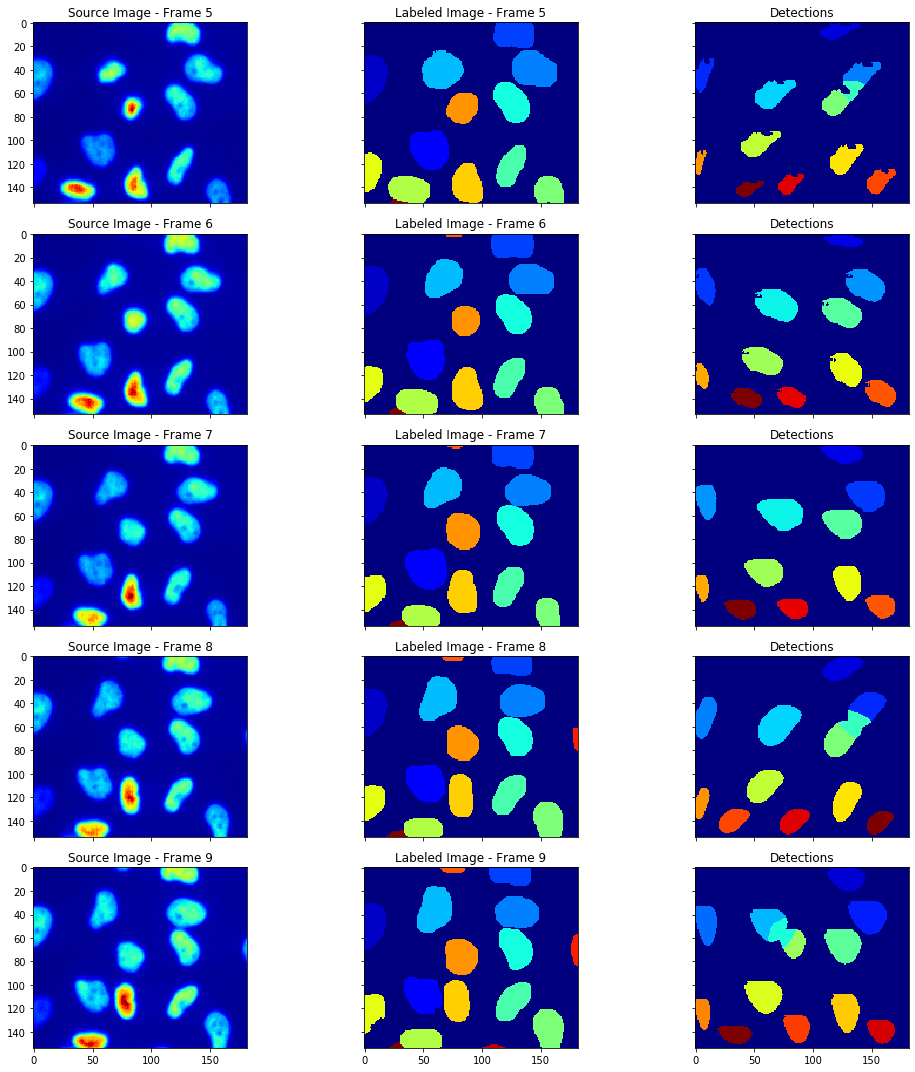

In [137]:
import matplotlib.pyplot as plt

from deepcell.utils.plot_utils import draw_detections

frame = 5
index = 0
image = X_test_temp[index:index + 1, frame:frame + fpb]
gt_mask = y_test_temp[index:index + 1, frame:frame + fpb]

# outputs = prediction_model.predict(image)
boxes = outputs[-5]
scores = outputs[-4]
labels = outputs[-3]
masks = outputs[-2]
final_scores = outputs[-1]

display = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
gt_mask = np.squeeze(gt_mask)

draw_list = []

for i in range(fpb):
    draw = 0.0 * np.tile(image[0, i].copy(), (1, 1, 3))

    # draw the masks
    draw = draw_masks(draw, boxes[0, i], scores[0, i], masks[0, i],
               score_threshold=0.5, binarize_threshold=0.5)

#     # draw detections
#     draw_detections(draw, boxes[0, i], scores[0, i], labels[0, i],
#                     label_to_name=lambda x: 'cell', score_threshold=0.5)

    draw_list.append(draw)

fig, axes = plt.subplots(ncols=3, nrows=fpb, figsize=(15, 15), sharex=True, sharey=True)
for i in range(fpb):
    axes[i, 0].imshow(display[i, ..., 0], cmap='jet')
    axes[i, 0].set_title('Source Image - Frame {}'.format(frame + i))

    axes[i, 1].imshow(gt_mask[i], cmap='jet')
    axes[i, 1].set_title('Labeled Image - Frame {}'.format(frame + i))

    axes[i, 2].imshow(draw_list[i][...,0], cmap='jet')
    axes[i, 2].set_title('Detections')

fig.tight_layout()
plt.show()

fig.tight_layout()
plt.show()

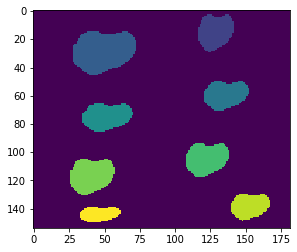

In [103]:
# draw_list[0] = ndi.label(draw_list[0])
plt.imshow(draw_list[2][...,0])

In [70]:

argmax_images = np.argmax(temp, axis=-1)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = temp[..., 2] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh
print("argmax_images_post_fgbg.shape", argmax_images_post_fgbg.shape)

labels = fg_thresh[..., 0]
distance = argmax_images_post_fgbg[..., 0]

local_maxi = peak_local_max(temp[...,-1], min_distance=15, 
                            exclude_border=False, indices=False, labels=labels)

markers = label(local_maxi)
print("markers shape", markers.shape)
print("distance shape", distance.shape)
print("image shape", image.shape)
watershed_images = watershed(-distance, markers, mask=labels)

watershed argmax shape: (154, 182, 1)
argmax_images_post_fgbg.shape (154, 182, 1)
markers shape (154, 182)
distance shape (154, 182)
image shape (1, 5, 154, 182, 1)


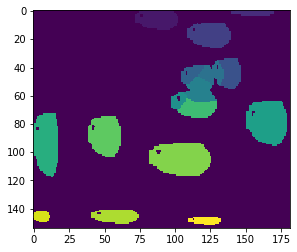

In [71]:
plt.imshow(watershed_images)

In [113]:
y_pred.shape

(1, 30, 154, 182, 1)

In [114]:
draw_list[0].shape

(154, 182, 3)

In [115]:
index

0

In [148]:
df = pd.concat([pd.concat(Lstats_allmovies[i]) for i in range(len(Lstats_allmovies))])
print('\n')
print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
print('\n')
# Total number of correct detections and incorrect detections
correct_det = int(df['correct_detections'].sum())
incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

print('Correct Detections: ', correct_det)
print('Incorrect Detections: ', incorrect_det)

# Total number of splits, merges, and catastrophes
splits = df['split'].sum()
merges = df['merge'].sum()
catastrophes = df['catastrophe'].sum()

print('Splits: ', splits)
print('Merges: ', merges)
print('Catastrophes: ', catastrophes)

# Average Recall, Precision, and Jaccard Index
recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
jaccard = df['jaccard'].mean()

print('Recall: ', recall)
print('Precision: ', precision)
print('Average Jaccard Index: ', jaccard)



mobilenetv2_fpb5_conv


Correct Detections:  581
Incorrect Detections:  458
Splits:  13
Merges:  7
Catastrophes:  12
Recall:  52.060931899641574
Precision:  55.91915303176131
Average Jaccard Index:  0.6212300672022402


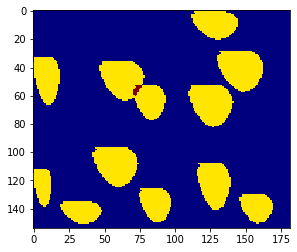

In [135]:
pred = y_pred[-1, -1, :, :, 0]
plt.imshow(draw_list[-1][...,0], cmap='jet')

In [150]:
os.getcwd()

'/notebooks/deepcell/notebooks'